## Load Preprocessed Data


In [1]:
import pandas as pd

train_path = "../../data/processed/irish-preprocessed-train.csv"
test_path  = "../../data/processed/irish-preprocessed-test.csv"
sol_path   = "../../data/processed/irish-preprocessed-sol.csv"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)
sol_df   = pd.read_csv(sol_path)  


## Prepare Features and Target


In [2]:
target_col = "Course"
id_col = "ID"

X_train = train_df.drop(columns=[target_col, id_col])
y_train = train_df[target_col]

X_test = test_df.drop(columns=[id_col])


## KNN Classification


In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 1. Hold-Out split (80/20) from training set
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

results = []

k_values = [1, 3, 5, 7, 9, 11, 15, 21, 31]

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    
    # Fit
    model.fit(X_tr, y_tr)
    
    # Hold-out predictions
    val_pred = model.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    
    # Cross-Val accuracy
    cv_acc = cross_val_score(model, X_train, y_train, cv=5).mean()

    results.append({
        "k": k,
        "holdout_acc": val_acc,
        "cv_acc": cv_acc
    })

res_df = pd.DataFrame(results)
print(res_df)


    k  holdout_acc  cv_acc
0   1       1.0000  0.9975
1   3       0.9875  0.9900
2   5       0.9875  0.9800
3   7       0.9625  0.9750
4   9       0.9625  0.9625
5  11       0.9500  0.9550
6  15       0.9625  0.9500
7  21       0.9250  0.9475
8  31       0.9125  0.9400


## KNN Accuracy

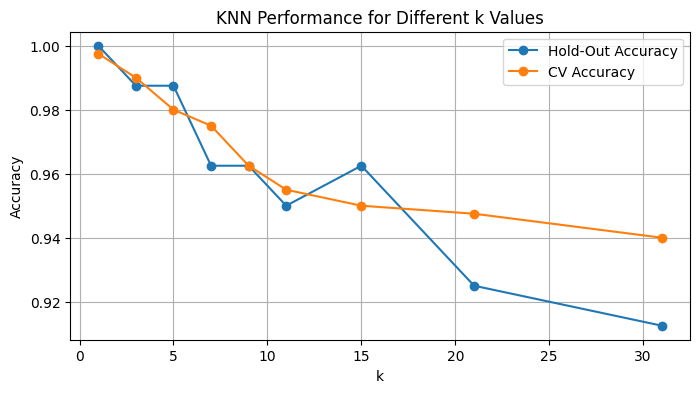

In [4]:
plt.figure(figsize=(8,4))
plt.plot(res_df["k"], res_df["holdout_acc"], marker="o", label="Hold-Out Accuracy")
plt.plot(res_df["k"], res_df["cv_acc"], marker="o", label="CV Accuracy")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.title("KNN Performance for Different k Values")
plt.legend()
plt.grid(True)
plt.show()

## KNN Test Evaluation

Best k based on CV accuracy: 1
Best k based on Holdout accuracy: 1

TEST SET RESULTS

Best k (CV): 1
Test Accuracy (CV-based model): 0.9700

Best k (Holdout): 1
Test Accuracy (Holdout-based model): 0.9700

CLASSIFICATION REPORT - CV-based Model
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        56
           1       0.96      0.98      0.97        44

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100


CLASSIFICATION REPORT - Holdout-based Model
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        56
           1       0.96      0.98      0.97        44

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100



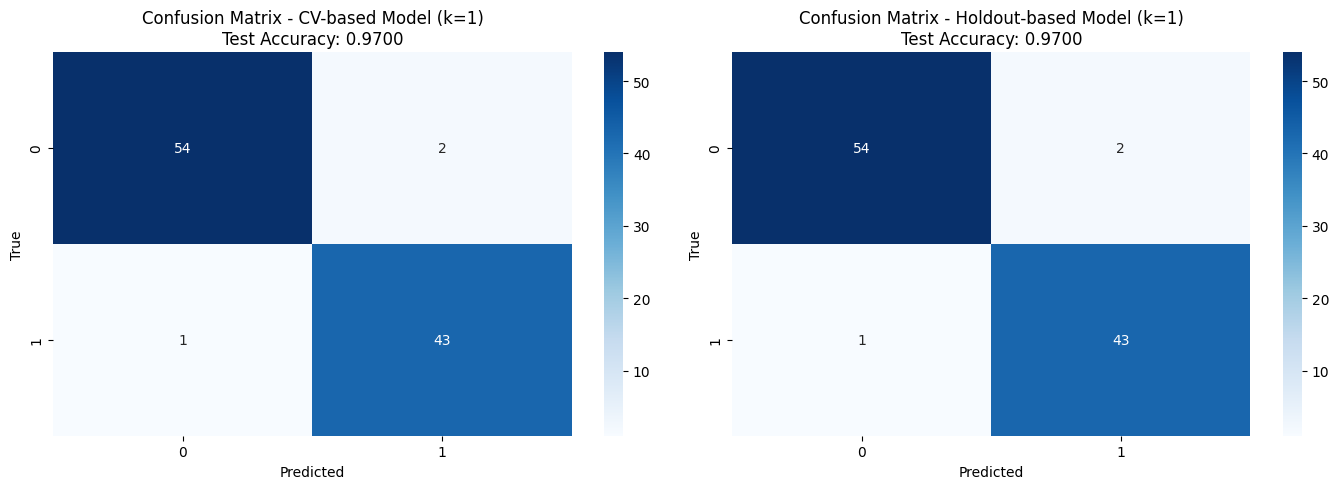

In [5]:
import seaborn as sns
import numpy as np

# Select best k based on CV accuracy
best_k_cv = int(res_df.sort_values("cv_acc", ascending=False).iloc[0]["k"])
print(f"Best k based on CV accuracy: {best_k_cv}")

# Select best k based on Holdout accuracy
best_k_holdout = int(res_df.sort_values("holdout_acc", ascending=False).iloc[0]["k"])
print(f"Best k based on Holdout accuracy: {best_k_holdout}\n")

# Train models with best k values on full training set
model_cv = KNeighborsClassifier(n_neighbors=best_k_cv)
model_cv.fit(X_train, y_train)

model_holdout = KNeighborsClassifier(n_neighbors=best_k_holdout)
model_holdout.fit(X_train, y_train)

# Make predictions on test set
y_test_pred_cv = model_cv.predict(X_test)
y_test_pred_holdout = model_holdout.predict(X_test)

# Get true labels from solution dataset
y_test_true = sol_df[target_col]

# Calculate accuracies
test_acc_cv = accuracy_score(y_test_true, y_test_pred_cv)
test_acc_holdout = accuracy_score(y_test_true, y_test_pred_holdout)

print("=" * 60)
print("TEST SET RESULTS")
print("=" * 60)
print(f"\nBest k (CV): {best_k_cv}")
print(f"Test Accuracy (CV-based model): {test_acc_cv:.4f}")
print(f"\nBest k (Holdout): {best_k_holdout}")
print(f"Test Accuracy (Holdout-based model): {test_acc_holdout:.4f}")

# Classification reports
print("\n" + "=" * 60)
print("CLASSIFICATION REPORT - CV-based Model")
print("=" * 60)
print(classification_report(y_test_true, y_test_pred_cv))

print("\n" + "=" * 60)
print("CLASSIFICATION REPORT - Holdout-based Model")
print("=" * 60)
print(classification_report(y_test_true, y_test_pred_holdout))

# Confusion matrices
cm_cv = confusion_matrix(y_test_true, y_test_pred_cv)
cm_holdout = confusion_matrix(y_test_true, y_test_pred_holdout)

# Visualize confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm_cv, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title(f"Confusion Matrix - CV-based Model (k={best_k_cv})\nTest Accuracy: {test_acc_cv:.4f}")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(cm_holdout, annot=True, fmt="d", cmap="Blues", ax=axes[1])
axes[1].set_title(f"Confusion Matrix - Holdout-based Model (k={best_k_holdout})\nTest Accuracy: {test_acc_holdout:.4f}")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()


## Decision Trees


In [6]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score

def _safe_depth(val):
    """Helper to safely convert potential None/NaN values for max_depth."""
    return None if (val is None or (isinstance(val, float) and np.isnan(val)) or pd.isna(val)) else int(val)


param_grid = []
for depth in [None, 5, 10]:
    for minsplit in [2, 20]:
        for minleaf in [1, 10]:
            for crit in ["gini", "entropy"]:
                param_grid.append({
                    "max_depth": depth, 
                    "min_samples_split": minsplit, 
                    "min_samples_leaf": minleaf, 
                    "criterion": crit
                })

print(f"Testing {len(param_grid)} parameter combinations...")


results_list = []

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for params in param_grid:
    # Define the model for this loop iteration
    model = DecisionTreeClassifier(
        max_depth=_safe_depth(params["max_depth"]),
        min_samples_split=int(params["min_samples_split"]),
        min_samples_leaf=int(params["min_samples_leaf"]),
        criterion=params["criterion"],
        class_weight="balanced",  # Important for imbalanced data
        random_state=42
    )

 
    model.fit(X_tr, y_tr)

    val_pred = model.predict(X_val)
    
   
    hold_acc = accuracy_score(y_val, val_pred)
    hold_f1 = f1_score(y_val, val_pred, average="macro")

    
    cv_acc_scores = cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring="accuracy", n_jobs=-1)
    cv_f1_scores = cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring="f1_macro", n_jobs=-1)
    
    cv_acc = cv_acc_scores.mean()
    cv_f1 = cv_f1_scores.mean()

    current_run = {
        **params, 
        "holdout_acc": hold_acc,
        "holdout_f1": hold_f1,
        "cv_acc": cv_acc,
        "cv_f1": cv_f1
    }
    results_list.append(current_run)


results_df = pd.DataFrame(results_list)

# Sort by the most important metrics
# 1st Priority: Best CV F1-score (most robust)
# 2nd Priority: Best CV Accuracy-score
# 3rd Priority: Best Hold-Out F1-score
sort_by = ["cv_f1", "cv_acc", "holdout_f1", "holdout_acc"]
final_results = results_df.sort_values(by=sort_by, ascending=False)

print("\n--- Hyperparameter Tuning Results (Top 10) ---")
display(final_results.head(10))


best_params_series = final_results.iloc[0]
print("\n--- Best Configuration Found ---")
print(best_params_series)


hyperparam_keys = ["max_depth", "min_samples_split", "min_samples_leaf", "criterion"]
final_model_params = best_params_series[hyperparam_keys].to_dict()

print("\n--- Hyperparameters for the Final Model ---")
print(final_model_params)

Testing 24 parameter combinations...

--- Hyperparameter Tuning Results (Top 10) ---


,max_depth,min_samples_split,min_samples_leaf,criterion,holdout_acc,holdout_f1,cv_acc,cv_f1
0,NaN,2,1,gini,1.0,1.0,1.0,1.0
1,NaN,2,1,entropy,1.0,1.0,1.0,1.0
4,NaN,20,1,gini,1.0,1.0,1.0,1.0
5,NaN,20,1,entropy,1.0,1.0,1.0,1.0
8,5.0,2,1,gini,1.0,1.0,1.0,1.0
9,5.0,2,1,entropy,1.0,1.0,1.0,1.0
12,5.0,20,1,gini,1.0,1.0,1.0,1.0
13,5.0,20,1,entropy,1.0,1.0,1.0,1.0
16,10.0,2,1,gini,1.0,1.0,1.0,1.0
17,10.0,2,1,entropy,1.0,1.0,1.0,1.0



--- Best Configuration Found ---
max_depth             NaN
min_samples_split       2
min_samples_leaf        1
criterion            gini
holdout_acc           1.0
holdout_f1            1.0
cv_acc                1.0
cv_f1                 1.0
Name: 0, dtype: object

--- Hyperparameters for the Final Model ---
{'max_depth': nan, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini'}


## Decision Tree Test Set Evaluation


Best Decision Tree hyperparameters:
  max_depth: nan
  min_samples_split: 2
  min_samples_leaf: 1
  criterion: gini

DECISION TREE TEST SET RESULTS

Best hyperparameters:
  max_depth: nan
  min_samples_split: 2
  min_samples_leaf: 1
  criterion: gini

Test Accuracy: 1.0000

CLASSIFICATION REPORT - Decision Tree
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        56
           1       1.00      1.00      1.00        44

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



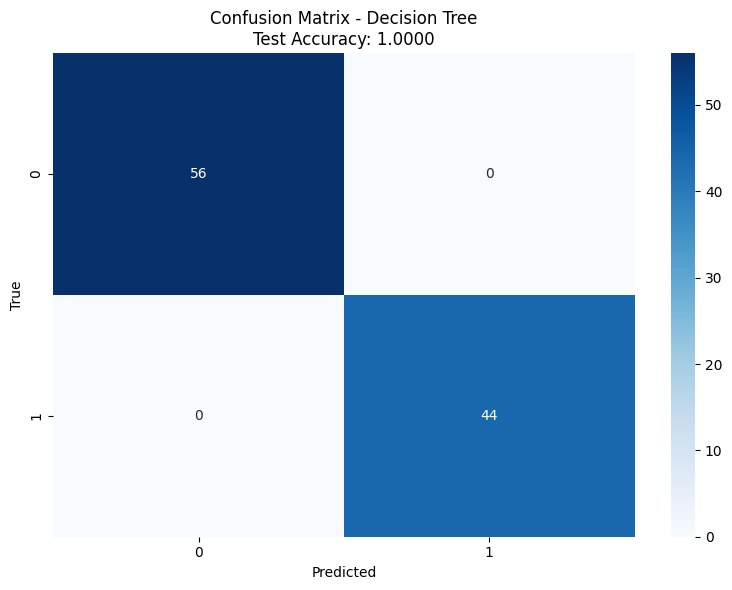

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Use the best hyperparameters found in the Decision Tree section
# The best model is stored in final_model_params
best_dt_params = final_model_params.copy()

print("Best Decision Tree hyperparameters:")
print(f"  max_depth: {best_dt_params['max_depth']}")
print(f"  min_samples_split: {int(best_dt_params['min_samples_split'])}")
print(f"  min_samples_leaf: {int(best_dt_params['min_samples_leaf'])}")
print(f"  criterion: {best_dt_params['criterion']}\n")

# Train final model with best hyperparameters on full training set
model_dt_best = DecisionTreeClassifier(
    max_depth=_safe_depth(best_dt_params['max_depth']),
    min_samples_split=int(best_dt_params['min_samples_split']),
    min_samples_leaf=int(best_dt_params['min_samples_leaf']),
    criterion=best_dt_params['criterion'],
    class_weight="balanced",  # Same as used in hyperparameter tuning
    random_state=42
)
model_dt_best.fit(X_train, y_train)

# Make predictions on test set
y_test_pred_dt = model_dt_best.predict(X_test)

# Get true labels from solution dataset
y_test_true = sol_df[target_col]

# Calculate accuracy
test_acc_dt = accuracy_score(y_test_true, y_test_pred_dt)

print("=" * 60)
print("DECISION TREE TEST SET RESULTS")
print("=" * 60)
print(f"\nBest hyperparameters:")
print(f"  max_depth: {best_dt_params['max_depth']}")
print(f"  min_samples_split: {int(best_dt_params['min_samples_split'])}")
print(f"  min_samples_leaf: {int(best_dt_params['min_samples_leaf'])}")
print(f"  criterion: {best_dt_params['criterion']}")
print(f"\nTest Accuracy: {test_acc_dt:.4f}")

# Classification report
print("\n" + "=" * 60)
print("CLASSIFICATION REPORT - Decision Tree")
print("=" * 60)
print(classification_report(y_test_true, y_test_pred_dt))

# Confusion matrix
cm_dt = confusion_matrix(y_test_true, y_test_pred_dt)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - Decision Tree\nTest Accuracy: {test_acc_dt:.4f}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


## Random Forest


In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score

def _safe_depth(val):
    """Helper to safely convert potential None/NaN values for max_depth."""
    return None if (val is None or (isinstance(val, float) and np.isnan(val)) or pd.isna(val)) else int(val)

# Define parameter grid for Random Forest
param_grid_rf = []
for n_est in [50, 100, 200]:
    for depth in [None, 5, 10]:
        for minsplit in [2, 10]:
            for minleaf in [1, 5]:
                for crit in ["gini", "entropy"]:
                    for max_feat in ["sqrt", "log2"]:
                        param_grid_rf.append({
                            "n_estimators": n_est,
                            "max_depth": depth, 
                            "min_samples_split": minsplit, 
                            "min_samples_leaf": minleaf, 
                            "criterion": crit,
                            "max_features": max_feat
                        })

print(f"Testing {len(param_grid_rf)} parameter combinations...")

# Evaluation Loop
results_list_rf = []
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for params in param_grid_rf:
    # Define the model for this loop iteration
    model = RandomForestClassifier(
        n_estimators=int(params["n_estimators"]),
        max_depth=_safe_depth(params["max_depth"]),
        min_samples_split=int(params["min_samples_split"]),
        min_samples_leaf=int(params["min_samples_leaf"]),
        criterion=params["criterion"],
        max_features=params["max_features"],
        class_weight="balanced",  # Important for imbalanced data
        random_state=42,
        n_jobs=-1
    )

    # Hold-Out Validation
    model.fit(X_tr, y_tr)
    val_pred = model.predict(X_val)
    
    # Calculate Hold-Out metrics
    hold_acc = accuracy_score(y_val, val_pred)
    hold_f1 = f1_score(y_val, val_pred, average="macro")

    # Cross-Validation (CV)
    cv_acc_scores = cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring="accuracy", n_jobs=-1)
    cv_f1_scores = cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring="f1_macro", n_jobs=-1)
    
    # Take the average of the 5 folds
    cv_acc = cv_acc_scores.mean()
    cv_f1 = cv_f1_scores.mean()

    # Store Results
    current_run = {
        **params,  # Add all parameters from the grid
        "holdout_acc": hold_acc,
        "holdout_f1": hold_f1,
        "cv_acc": cv_acc,
        "cv_f1": cv_f1
    }
    results_list_rf.append(current_run)

# Model Selection
results_df_rf = pd.DataFrame(results_list_rf)

# Sort by the most important metrics
# 1st Priority: Best CV F1-score (most robust)
# 2nd Priority: Best CV Accuracy-score
# 3rd Priority: Best Hold-Out F1-score
sort_by = ["cv_f1", "cv_acc", "holdout_f1", "holdout_acc"]
final_results_rf = results_df_rf.sort_values(by=sort_by, ascending=False)

print("\n--- Hyperparameter Tuning Results (Top 10) ---")
display(final_results_rf.head(10))

# Select the Best Parameters
best_params_series_rf = final_results_rf.iloc[0]
print("\n--- Best Configuration Found ---")
print(best_params_series_rf)

# Filter out only the model hyperparameters
hyperparam_keys_rf = ["n_estimators", "max_depth", "min_samples_split", "min_samples_leaf", "criterion", "max_features"]
final_model_params_rf = best_params_series_rf[hyperparam_keys_rf].to_dict()

print("\n--- Hyperparameters for the Final Model ---")
print(final_model_params_rf)


Testing 144 parameter combinations...

--- Hyperparameter Tuning Results (Top 10) ---


,n_estimators,max_depth,min_samples_split,min_samples_leaf,criterion,max_features,holdout_acc,holdout_f1,cv_acc,cv_f1
48,100,NaN,2,1,gini,sqrt,1.0,1.0,0.9975,0.997468
49,100,NaN,2,1,gini,log2,1.0,1.0,0.9975,0.997468
64,100,5.0,2,1,gini,sqrt,1.0,1.0,0.9975,0.997468
65,100,5.0,2,1,gini,log2,1.0,1.0,0.9975,0.997468
72,100,5.0,10,1,gini,sqrt,1.0,1.0,0.9975,0.997468
73,100,5.0,10,1,gini,log2,1.0,1.0,0.9975,0.997468
74,100,5.0,10,1,entropy,sqrt,1.0,1.0,0.9975,0.997468
75,100,5.0,10,1,entropy,log2,1.0,1.0,0.9975,0.997468
80,100,10.0,2,1,gini,sqrt,1.0,1.0,0.9975,0.997468
81,100,10.0,2,1,gini,log2,1.0,1.0,0.9975,0.997468



--- Best Configuration Found ---
n_estimators              100
max_depth                 NaN
min_samples_split           2
min_samples_leaf            1
criterion                gini
max_features             sqrt
holdout_acc               1.0
holdout_f1                1.0
cv_acc                 0.9975
cv_f1                0.997468
Name: 48, dtype: object

--- Hyperparameters for the Final Model ---
{'n_estimators': 100, 'max_depth': nan, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini', 'max_features': 'sqrt'}


## Random Forest Test Set Evaluation


Best Random Forest hyperparameters:
  n_estimators: 100
  max_depth: nan
  min_samples_split: 2
  min_samples_leaf: 1
  criterion: gini
  max_features: sqrt

RANDOM FOREST TEST SET RESULTS

Best hyperparameters:
  n_estimators: 100
  max_depth: nan
  min_samples_split: 2
  min_samples_leaf: 1
  criterion: gini
  max_features: sqrt

Test Accuracy: 1.0000

CLASSIFICATION REPORT - Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        56
           1       1.00      1.00      1.00        44

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



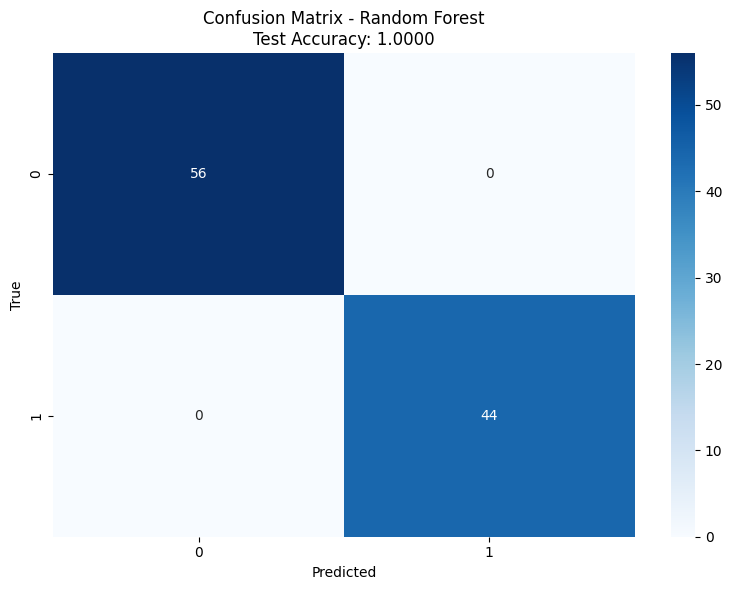

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Use the best hyperparameters found in the Random Forest section
# The best model is stored in final_model_params_rf
best_rf_params = final_model_params_rf.copy()

print("Best Random Forest hyperparameters:")
print(f"  n_estimators: {int(best_rf_params['n_estimators'])}")
print(f"  max_depth: {best_rf_params['max_depth']}")
print(f"  min_samples_split: {int(best_rf_params['min_samples_split'])}")
print(f"  min_samples_leaf: {int(best_rf_params['min_samples_leaf'])}")
print(f"  criterion: {best_rf_params['criterion']}")
print(f"  max_features: {best_rf_params['max_features']}\n")

# Train final model with best hyperparameters on full training set
model_rf_best = RandomForestClassifier(
    n_estimators=int(best_rf_params['n_estimators']),
    max_depth=_safe_depth(best_rf_params['max_depth']),
    min_samples_split=int(best_rf_params['min_samples_split']),
    min_samples_leaf=int(best_rf_params['min_samples_leaf']),
    criterion=best_rf_params['criterion'],
    max_features=best_rf_params['max_features'],
    class_weight="balanced",  # Same as used in hyperparameter tuning
    random_state=42,
    n_jobs=-1
)
model_rf_best.fit(X_train, y_train)

# Make predictions on test set
y_test_pred_rf = model_rf_best.predict(X_test)

# Get true labels from solution dataset
y_test_true = sol_df[target_col]

# Calculate accuracy
test_acc_rf = accuracy_score(y_test_true, y_test_pred_rf)

print("=" * 60)
print("RANDOM FOREST TEST SET RESULTS")
print("=" * 60)
print(f"\nBest hyperparameters:")
print(f"  n_estimators: {int(best_rf_params['n_estimators'])}")
print(f"  max_depth: {best_rf_params['max_depth']}")
print(f"  min_samples_split: {int(best_rf_params['min_samples_split'])}")
print(f"  min_samples_leaf: {int(best_rf_params['min_samples_leaf'])}")
print(f"  criterion: {best_rf_params['criterion']}")
print(f"  max_features: {best_rf_params['max_features']}")
print(f"\nTest Accuracy: {test_acc_rf:.4f}")

# Classification report
print("\n" + "=" * 60)
print("CLASSIFICATION REPORT - Random Forest")
print("=" * 60)
print(classification_report(y_test_true, y_test_pred_rf))

# Confusion matrix
cm_rf = confusion_matrix(y_test_true, y_test_pred_rf)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - Random Forest\nTest Accuracy: {test_acc_rf:.4f}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
